In [1]:
import mapper_eBOSS_QSO
import pyccl as ccl
import numpy as np
import pylab as plt
import pymaster as nmt

In [2]:
NGC_1_config = {'data_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO_clustering_data-NGC-vDR16.fits'], 
          'random_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO_clustering_random-NGC-vDR16.fits'],
          'z_edges':[0, 1.5],
          'nside':512}

NGC_2_config = {'data_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO_clustering_data-NGC-vDR16.fits'], 
          'random_catalogs':['/home/zcapjru/PhD/Data/eBOSS_QSO_clustering_random-NGC-vDR16.fits'],
          'z_edges':[1.5, 3],
          'nside':512}

In [3]:
NGC_1_maps = mapper_eBOSS_QSO.MappereBOSSQSO(NGC_1_config)
NGC_2_maps = mapper_eBOSS_QSO.MappereBOSSQSO(NGC_2_config)

In [4]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.049, h=0.67, sigma8=0.81, n_s=0.96)
b_ngc = 2.37*np.ones(200) 
b_sgc = 2.32 *np.ones(200) 

In [5]:
# Initialize binning scheme with 20 ells per bandpower
nside = 512
bands = nmt.NmtBin.from_nside_linear(nside, 30)

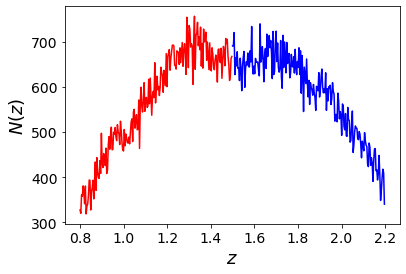

In [6]:
NGC_nz_1 = NGC_1_maps.get_nz()
NGC_nz_2 = NGC_2_maps.get_nz()
plt.xlabel('$z$',fontsize=18)
plt.ylabel('$N(z)$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(NGC_nz_1[1], NGC_nz_1[0], 'r-')
plt.plot(NGC_nz_2[1], NGC_nz_2[0], 'b-')
plt.show()

In [7]:
NGC_z_1 = NGC_nz_1[1]
NGC_dNdz_1 = NGC_nz_1[0]

NGC_z_2 = NGC_nz_2[1]
NGC_dNdz_2 = NGC_nz_2[0]

In [8]:
print(len(NGC_z_1))
print(len(NGC_dNdz_1))

200
200


In [9]:
NGC_quasar1 = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(NGC_z_1,NGC_dNdz_1), bias=(NGC_z_1,b_ngc))
NGC_quasar2 = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(NGC_z_2,NGC_dNdz_2), bias=(NGC_z_2,b_ngc))

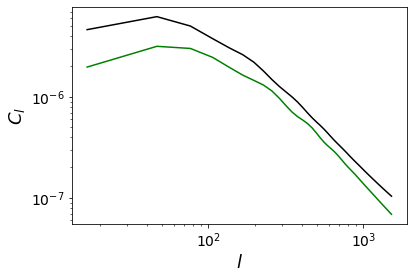

In [10]:
#ell = np.arange(2, 2000)
ell_arr = bands.get_effective_ells()
NGC_theory_11 = ccl.angular_cl(cosmo, NGC_quasar1, NGC_quasar1, ell_arr) 
NGC_theory_12 = ccl.angular_cl(cosmo, NGC_quasar1, NGC_quasar2, ell_arr) 
NGC_theory_22 = ccl.angular_cl(cosmo, NGC_quasar2, NGC_quasar2, ell_arr) 

plt.xlabel('$l$',fontsize=18)
plt.ylabel('$C_l$',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.plot(ell_arr, NGC_theory_11, 'k-')
plt.plot(ell_arr, NGC_theory_12, 'r-')
plt.plot(ell_arr, NGC_theory_22, 'g-')
plt.show()

In [11]:
def compute_cl(f_a, f_b, wsp):
    # Compute the power spectrum (a la anafast) of the masked fields
    # Note that we only use n_iter=0 here to speed up the computation,
    # but the default value of 3 is recommended in general.
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    # Decouple power spectrum into bandpowers inverting the coupling matrix
    cl_decoupled = wsp.decouple_cell(cl_coupled) #removed bias here

    return cl_decoupled

In [13]:
# Read healpix maps and initialize a spin-0 and spin-2 field
NGC_delta_1 = NGC_1_maps.get_signal_map()
NGC_delta_2 = NGC_2_maps.get_signal_map() 
NGC_mask_1  = NGC_1_maps.get_mask()
NGC_mask_2  = NGC_2_maps.get_mask() 

NGC_f_1 =  NGC_1_maps.get_nmt_field(NGC_delta_1, NGC_mask_1)
NGC_f_2 =  NGC_2_maps.get_nmt_field(NGC_delta_2, NGC_mask_2)

In [14]:
NGC_w_11 = nmt.NmtWorkspace()
NGC_w_11.compute_coupling_matrix(NGC_f_1, NGC_f_1, bands)

NGC_w_12 = nmt.NmtWorkspace()
NGC_w_12.compute_coupling_matrix(NGC_f_1, NGC_f_2, bands)

NGC_w_22 = nmt.NmtWorkspace()
NGC_w_22.compute_coupling_matrix(NGC_f_2, NGC_f_2, bands)

In [15]:
NGC_empirical_11 = compute_cl(NGC_f_1, NGC_f_1, NGC_w_11)
NGC_empirical_12 = compute_cl(NGC_f_1, NGC_f_2, NGC_w_12)
NGC_empirical_22 = compute_cl(NGC_f_2, NGC_f_2, NGC_w_22)

In [16]:
NGC_nl_11 = NGC_1_maps.get_nl_coupled() 
NGC_nl_22 = NGC_2_maps.get_nl_coupled() 

NGC_nl_11 = NGC_w_11.decouple_cell(NGC_nl_11)
NGC_nl_22 = NGC_w_22.decouple_cell(NGC_nl_22)

In [17]:
NGC_nn_empirical_11 = NGC_empirical_11 - NGC_nl_11
NGC_nn_empirical_22 = NGC_empirical_22 - NGC_nl_22

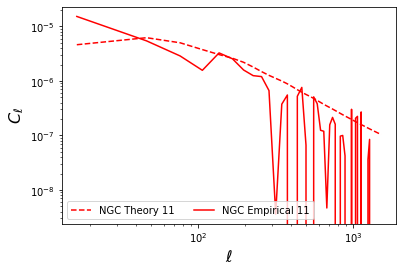

In [18]:
plt.plot(ell_arr, NGC_theory_11, 'r--', label='NGC Theory 11')
plt.plot(ell_arr, NGC_nn_empirical_11[0], 'r-', label='NGC Empirical 11')

plt.loglog()
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

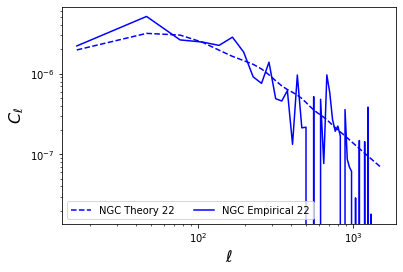

In [19]:
plt.plot(ell_arr, NGC_theory_22, 'b--', label='NGC Theory 22')
plt.plot(ell_arr, NGC_nn_empirical_22[0], 'b-', label='NGC Empirical 22')

plt.loglog()
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()